<h1 style="color: green">Covid Tracker</h1>
<h2 style="color: green">Recovery Data</h2>
<hr style="border: 1px solid darkgreen"/>

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .master("local") \
    .appName("Recoveries Tracker") \
    .getOrCreate()

In [49]:
df_i = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('../datasets/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv') \
    .select(col("UID"), col("Admin2"), col("Province_State"), col("1/21/22")) \
    .withColumnRenamed("UID", "id_i") \
    .withColumnRenamed("Admin2", "City_i") \
    .withColumnRenamed("Province_State", "State_i") \
    .withColumnRenamed("1/21/22", "1_21_22_i")

df_d = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("../datasets/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv") \
    .select(col("UID"), col("Admin2"), col("Province_State"), col("1/21/22")) \
    .withColumnRenamed("UID", "id_d") \
    .withColumnRenamed("Admin2", "City_d") \
    .withColumnRenamed("Province_State", "State_d") \
    .withColumnRenamed("1/21/22", "1_21_22_d")

df = df_i.join(df_d, col("id_i") == col("id_d"), "inner").createOrReplaceTempView("RecoveryInfo")



<BarContainer object of 56 artists>

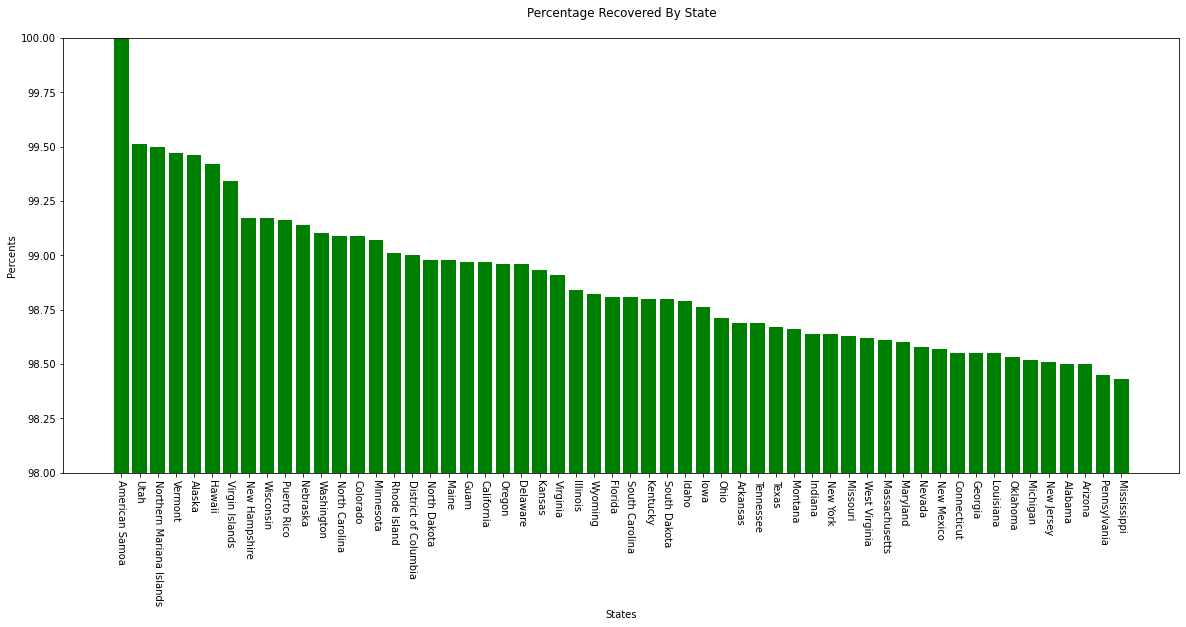

In [50]:
perc_df = spark.sql("""
    SELECT State_d, ROUND((1 - SUM(1_21_22_d) / SUM(1_21_22_i)) * 100, 2) AS PercentRecovered
    FROM RecoveryInfo 
    WHERE State_d NOT LIKE('%Princess%')
    GROUP BY State_d ORDER BY PercentRecovered DESC""").toPandas()

x = perc_df["State_d"]
y = perc_df["PercentRecovered"]

plt.title("Percentage Recovered By State\n")
plt.rcParams["figure.figsize"] = (20,8)
plt.ylim((98, 100))
plt.xticks(rotation = -90)
plt.xlabel("States")
plt.ylabel("Percents")
plt.bar(x, y, color = "green")



In [ ]:
spark.catalog.dropTempView("RecoveryInfo")
spark.stop()